OPRE 607 - BUSINESS ANALYTICS FINAL PROJECT
Portfolio Optimization for Technology Sector Investments

Analyzing portfolio of 7 tech stocks: AAPL, MSFT, GOOGL, AMZN, NVDA, META, TSLA
Data range: 2020-01-01 to 2025-11-10


STEP 1: FETCHING MARKET DATA
--------------------------------------------------------------------------------
Fetching real market data...
  Downloaded 2730 days of real price data for 7 stocks
  Date range: 2015-01-02 to 2025-11-07

  Actual Annual Expected Returns:
    AAPL: 26.40%
    MSFT: 26.92%
    GOOGL: 25.95%
    AMZN: 30.95%
    NVDA: 66.95%
    META: 26.34%
    TSLA: 47.94%
  Validating data quality...
  NVDA: 2 days with >20% daily moves
  META: 4 days with >20% daily moves
  TSLA: 3 days with >20% daily moves
    Capping AMZN return at 30.0% (was 30.9%)
    Capping NVDA return at 30.0% (was 67.0%)
    Capping TSLA return at 30.0% (was 47.9%)
  Data validation complete
  Fetching real Fama-French factors...
  Downloaded real Fama-French factors
  Fetching r

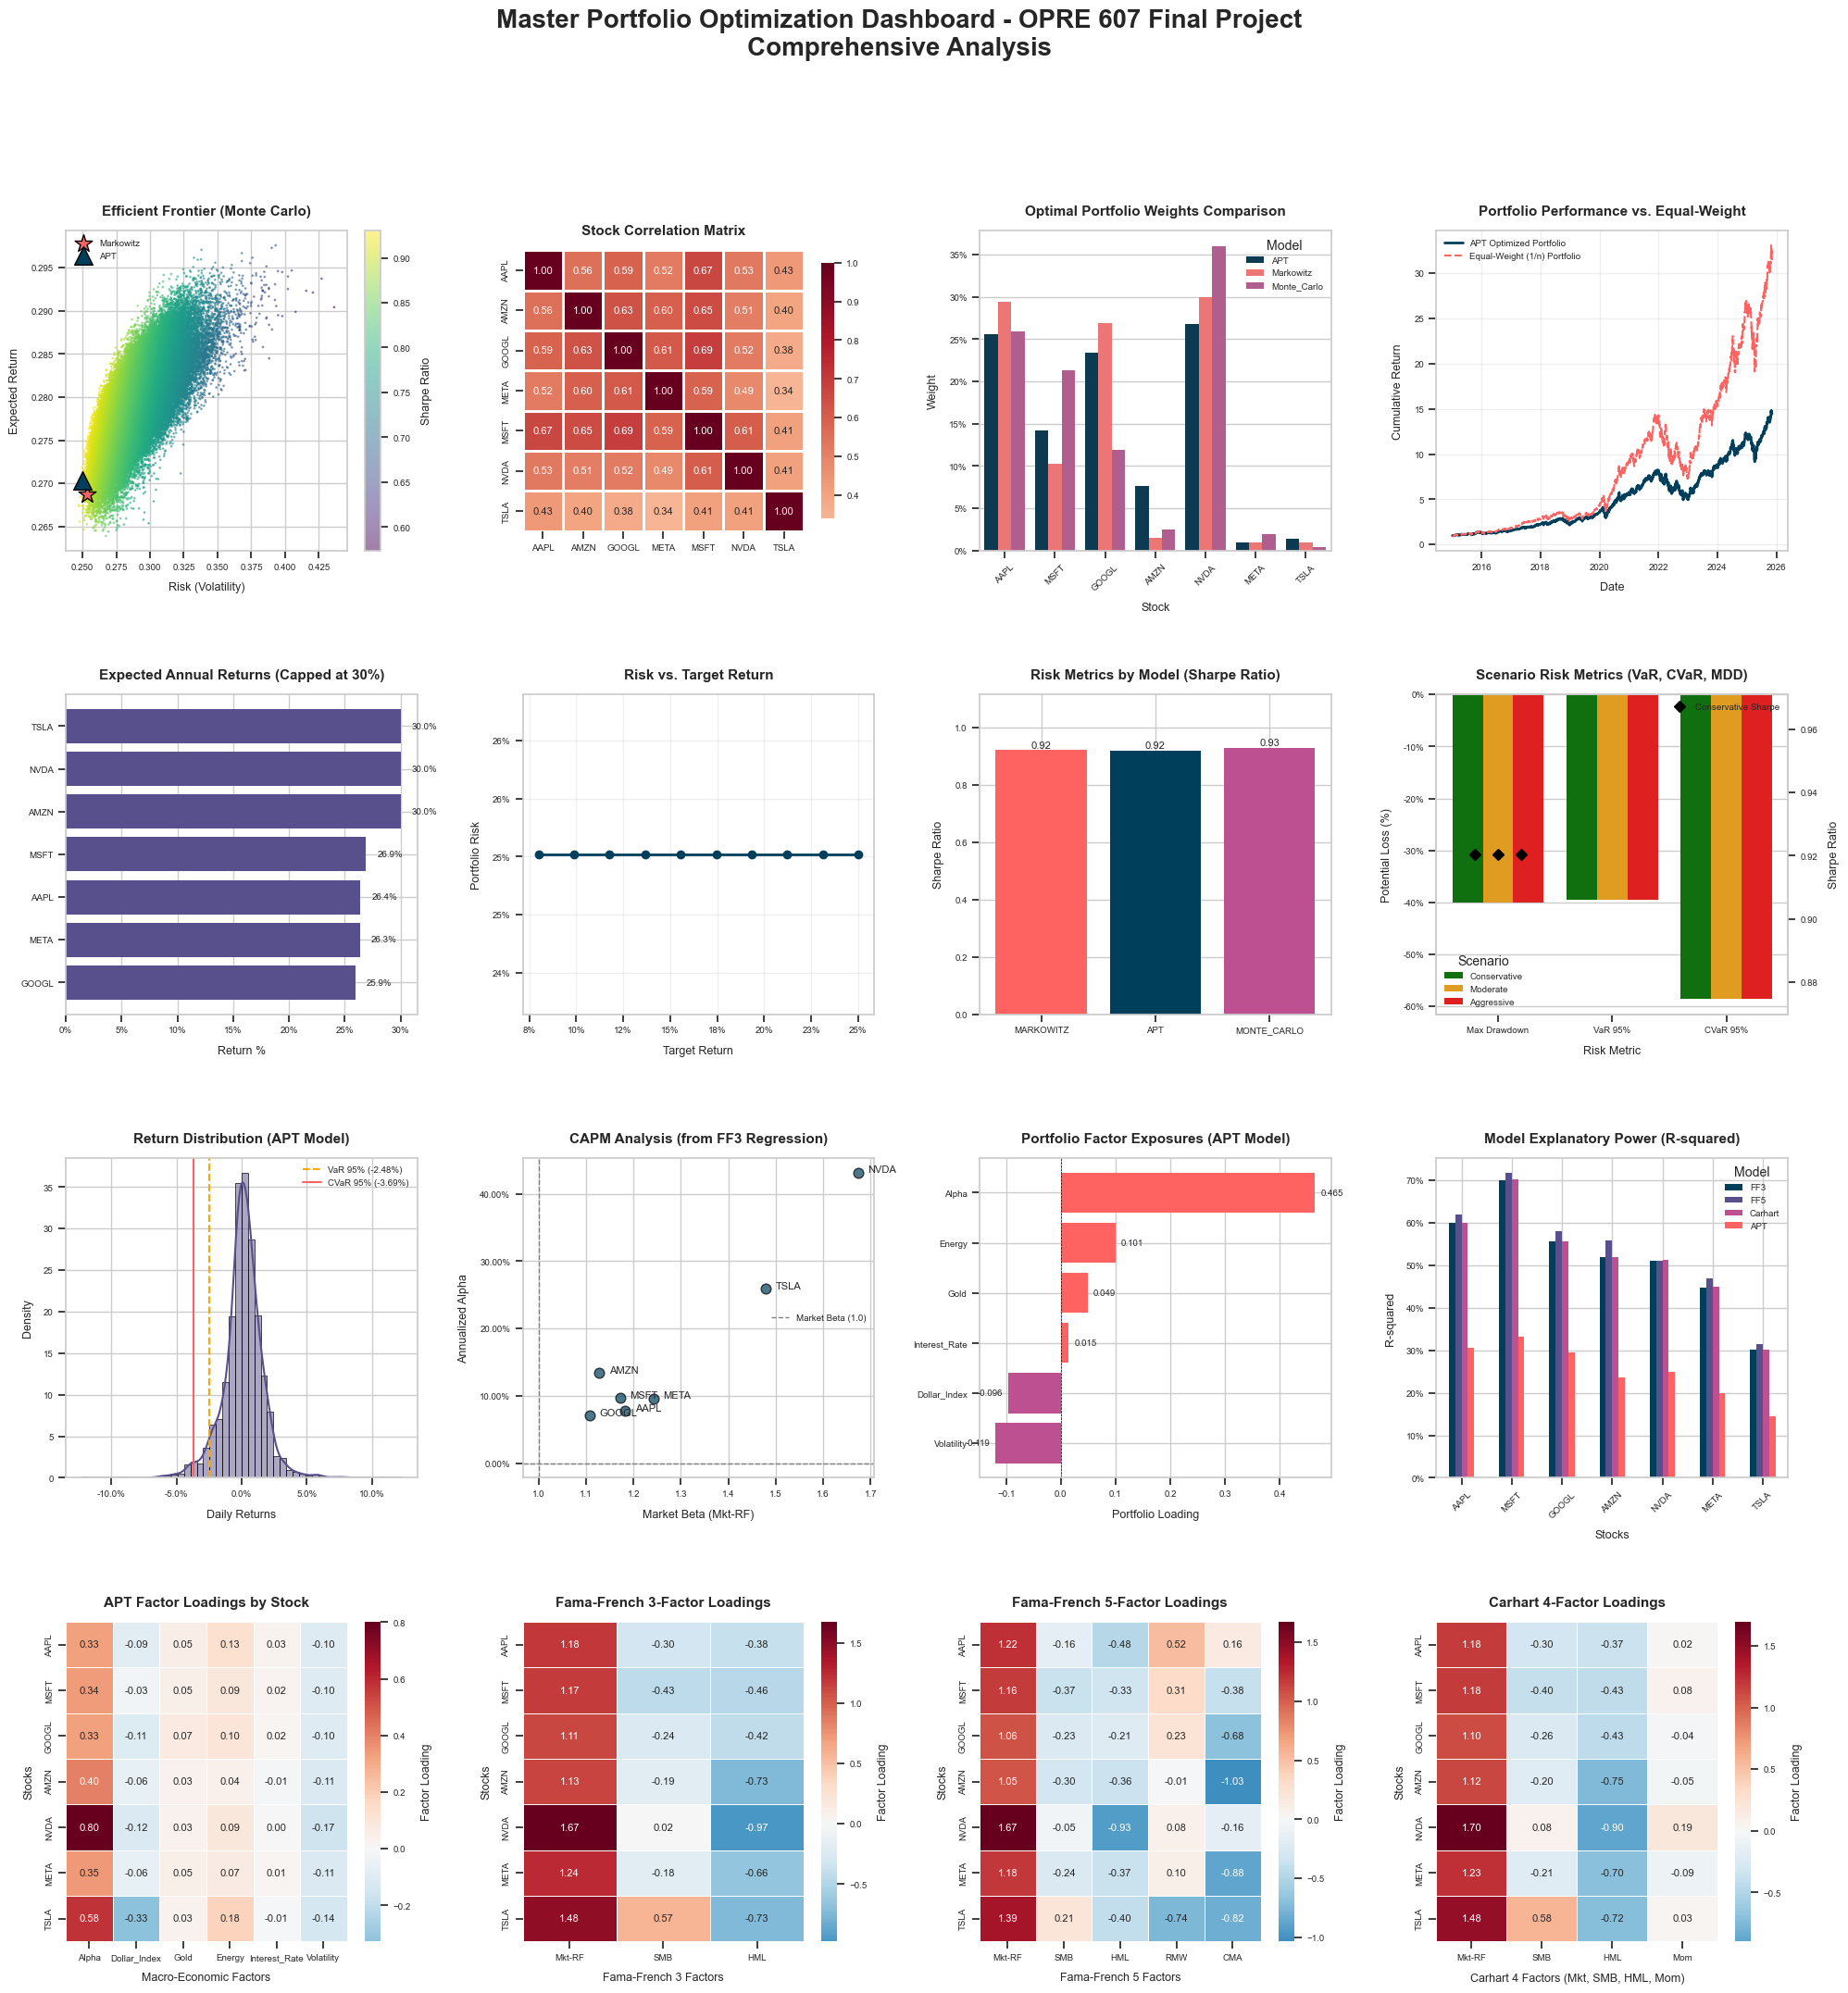



STEP 7: GENERATING EXCEL FILE
--------------------------------------------------------------------------------
Creating Excel workbook...
  Executive Summary created
  Data sheet created
  Sensitivity sheet created
  Solver-Ready sheet created
  Dashboard created
  Factor Loadings sheet created
  Assumptions sheet created
  Excel file saved: Tech_Portfolio_Report.xlsx

ANALYSES COMPLETE!

  1. Excel File: Tech_Portfolio_Report.xlsx
     - Executive Summary sheet
     - Solver-Ready optimization model
     - What-If Analysis scenarios
     - Comprehensive data tables
     - Assumptions & Limitations
     - FF3, FF5, and Carhart loadings added to 'Factor Loadings' tab

  2. Dashboard: Tech_Portfolio_Dashboard.png
     - Efficient Frontier, Correlation, Weights, Performance
     - Risk Metrics, Sensitivity, Return Distribution
     - CAPM, APT, FF3, FF5, Carhart Loadings
     - R-Squared Analysis & Portfolio Factor Exposure



In [1]:
#!/usr/bin/env python
"""
OPRE 607 - Business Analytics Final Project
Title: Portfolio Optimization for Tech Sector Investment

BUSINESS PROBLEM:
An investment firm managing a $10 million technology sector portfolio needs to 
optimize asset allocation across 7 major tech stocks to maximize risk-adjusted 
returns while adhering to diversification constraints and risk management policies.

"""

import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import warnings
from openpyxl import Workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side, NamedStyle
from openpyxl.chart import ScatterChart, Reference, Series, BarChart, LineChart
from openpyxl.worksheet.table import Table, TableStyleInfo
from openpyxl.worksheet.datavalidation import DataValidation
from openpyxl.workbook.defined_name import DefinedName

warnings.filterwarnings('ignore')

# Professional color scheme for visualizations
PORTFOLIO_COLORS = {
    'primary': '003f5c',
    'secondary': '58508d',
    'accent': 'bc5090',
    'success': 'ff6361',
    'warning': 'ffa600',
    'neutral': '7a5195',
    'light': 'F6F7F8',
    'dark': '2D3436',
    'table_header': '003f5c',
    'table_row1': 'f0f4f7',
    'table_row2': 'FFFFFF'
}

# Matplotlib configuration for professional charts
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=0.85)
plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.size': 8,
    'axes.labelsize': 9,
    'axes.titlesize': 11,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'figure.titlesize': 13,
    'axes.titlepad': 12,
    'axes.labelpad': 8
})


class EnhancedPortfolioOptimizer:
    """
    Comprehensive portfolio optimization engine implementing multiple 
    asset pricing models.
    
    Models Implemented:
    - Markowitz Mean-Variance Optimization
    - Arbitrage Pricing Theory (APT)
    - Monte Carlo Simulation
    - Fama-French Factor Models (3-factor and 5-factor)
    - Carhart 4-factor Model
    """
    
    def __init__(self, tickers, start_date='2020-01-01', end_date=None):
        """Initialize portfolio optimizer with stock tickers and date range."""
        self.tickers = tickers
        self.start_date = start_date
        
        if end_date is None:
            self.end_date = datetime.now().strftime('%Y-%m-%d')
        else:
            self.end_date = end_date
            
        self.model_params = {
            'initial_investment': 10000000,   # $10 million portfolio
            'risk_free_rate': 0.04,   # 4% annual risk-free rate (US Treasury)
            'transaction_cost': 0.001,   # 0.1% transaction cost
            'confidence_level': 0.95,    # 95% confidence for risk metrics
            'trading_days': 252,     # Standard trading days per year
            'min_investment': 0.01,    # Minimum 1% position size
            'max_investment': 0.30,    # Maximum 30% position size (diversification)
            'target_return_cap': 0.30,     # Cap returns at 30% (realistic for tech)
            'max_volatility': 0.35,     # Maximum 35% portfolio volatility
            'min_stocks_active': 7    # Minimum 7 stocks for diversification
        }
        
        # Storage for different model results
        self.models = {
            'markowitz': {},
            'apt': {},
            'ff3': {},
            'ff5': {},
            'carhart': {},
            'monte_carlo': {}
        }
        
        self.factor_data = {}
        self.factor_loadings = {}
        self.sensitivity_results = pd.DataFrame()
        self.what_if_scenarios = {}
    
    def fetch_all_data(self):
        """
        Main data pipeline: Fetch real prices from Yahoo Finance and factor data.
        """
        print("Fetching real market data...")
        
        # Fetch real stock prices from Yahoo Finance
        self.fetch_real_stock_data()
        
        # Validate data quality
        self.validate_data_quality()
        
        # Fetch real Fama-French factors
        self.fetch_real_fama_french_factors()
        
        # Fetch real macro factors
        self.fetch_real_macro_factors()
        
        # Calculate factor loadings
        self.calculate_factor_loadings()
        
        print("Real data preparation complete!")
        return True
    
    def fetch_real_stock_data(self):
        """
        Fetch real stock price data from Yahoo Finance.
        """
        print("  Downloading real stock prices from Yahoo Finance...")
        
        try:
            # Download real stock data
            raw_data = yf.download(
                self.tickers, 
                start=self.start_date, 
                end=self.end_date,
                progress=False
            )
            
            # Extract adjusted close prices
            if isinstance(raw_data.columns, pd.MultiIndex):
                if 'Adj Close' in raw_data.columns.levels[0]:
                    self.prices = raw_data['Adj Close']
                else:
                    self.prices = raw_data['Close']
            else:
                self.prices = raw_data[['Adj Close']] if 'Adj Close' in raw_data.columns else raw_data
            
            # Ensure we have data for all tickers
            if isinstance(self.prices, pd.Series):
                self.prices = pd.DataFrame(self.prices)
            
            # Forward fill missing data (holidays, etc.)
            self.prices = self.prices.ffill()
            
            missing_tickers = [t for t in self.tickers if t not in self.prices.columns]
            if missing_tickers:
                print(f"  WARNING: Could not fetch data for: {', '.join(missing_tickers)}")
                # Filter out missing tickers from our list
                self.tickers = [t for t in self.tickers if t in self.prices.columns]
            
            # Calculate returns
            self.returns = self.prices.pct_change().dropna()
            
            # Remove any remaining NaN values
            self.returns = self.returns.dropna()
            
            # Calculate statistics
            self.expected_returns = self.returns.mean() * self.model_params['trading_days']
            self.cov_matrix = self.returns.cov() * self.model_params['trading_days']
            self.corr_matrix = self.returns.corr()
            
            print(f"  Downloaded {len(self.prices)} days of real price data for {len(self.tickers)} stocks")
            print(f"  Date range: {self.prices.index[0].date()} to {self.prices.index[-1].date()}")
            
            # Display actual returns for validation
            print("\n  Actual Annual Expected Returns:")
            for ticker in self.tickers:
                if ticker in self.expected_returns:
                    print(f"    {ticker}: {self.expected_returns[ticker]:.2%}")
            
        except Exception as e:
            print(f" Error fetching real data: {e}")
    
    def fetch_real_fama_french_factors(self):
        """
        Fetch real Fama-French factors from Ken French's data library.
        """
        print("  Fetching real Fama-French factors...")
        
        try:
            # Fetch Fama-French 3-factor data
            ff3_data_dict = pdr.get_data_famafrench(
                'F-F_Research_Data_Factors_daily',
                start=self.start_date,
                end=self.end_date
            )
            
            if ff3_data_dict and 0 in ff3_data_dict:
                ff3_data = ff3_data_dict[0]
                # Convert to decimal format
                ff3_data = ff3_data / 100.0
                ff3_data.index = pd.to_datetime(ff3_data.index)
                
                # Align with stock data dates
                common_dates = self.returns.index.intersection(ff3_data.index)
                self.factor_data['ff3'] = ff3_data.loc[common_dates]
            else:
                print("    Could not fetch FF3 data.")
            
            # Fetch Fama-French 5-factor data
            ff5_data_dict = pdr.get_data_famafrench(
                'F-F_Research_Data_5_Factors_2x3_daily',
                start=self.start_date,
                end=self.end_date
            )
            
            if ff5_data_dict and 0 in ff5_data_dict:
                ff5_data = ff5_data_dict[0]
                ff5_data = ff5_data / 100.0
                ff5_data.index = pd.to_datetime(ff5_data.index)
                common_dates = self.returns.index.intersection(ff5_data.index)
                self.factor_data['ff5'] = ff5_data.loc[common_dates]
            else:
                print("    Could not fetch FF5 data.")
                
            # Fetch momentum factor
            mom_data_dict = pdr.get_data_famafrench(
                'F-F_Momentum_Factor_daily',
                start=self.start_date,
                end=self.end_date
            )
            
            if mom_data_dict and 0 in mom_data_dict:
                mom_data = mom_data_dict[0]
                mom_data = mom_data / 100.0
                mom_data.index = pd.to_datetime(mom_data.index)
                common_dates = self.returns.index.intersection(mom_data.index)
                self.factor_data['momentum'] = mom_data.loc[common_dates]
            else:
                print("    Could not fetch Momentum data.")
                
            print(f"  Downloaded real Fama-French factors")
            
        except Exception as e:
            print(f"  Error fetching Fama-French data: {e}")
    
    def fetch_real_macro_factors(self):
        """
        Fetch real macroeconomic factors for APT model.
        Using market indices as proxies for macro factors.
        """
        print("  Fetching real macro factors for APT...")
        
        try:
            # Define macro factor proxies
            macro_tickers = {
                '^VIX': 'Volatility',     # VIX for market volatility
                '^TNX': 'Interest_Rate',    # 10-year Treasury yield
                'DX-Y.NYB': 'Dollar_Index', # US Dollar Index
                'GLD': 'Gold',             # Gold as inflation hedge
                'XLE': 'Energy'             # Energy sector ETF
            }
            
            # Download macro data
            macro_data = yf.download(
                list(macro_tickers.keys()),
                start=self.start_date,
                end=self.end_date,
                progress=False
            )
            
            # Extract adjusted close prices
            if isinstance(macro_data.columns, pd.MultiIndex):
                macro_prices = macro_data['Adj Close'] if 'Adj Close' in macro_data.columns.levels[0] else macro_data['Close']
            else:
                macro_prices = macro_data
            
            # Rename columns
            macro_prices.columns = [macro_tickers.get(col, col) for col in macro_prices.columns]
            
            # Calculate returns
            macro_returns = macro_prices.pct_change().dropna()
            
            # Align with stock data
            common_dates = self.returns.index.intersection(macro_returns.index)
            self.factor_data['macro'] = macro_returns.loc[common_dates]
            
            print(f"  Downloaded real macro factors ({len(common_dates)} observations)")
            
        except Exception as e:
            print(f"  Error fetching macro data: {e}")
    
    def save_data_to_excel(self, filename="Portfolio_Data.xlsx"):
        """
        Save fetched and computed data (prices, returns, expected returns, covariances, etc.)
        to Excel file.
        """
        print(f"Saving portfolio data to Excel: {filename}")

        wb = Workbook()
        ws_prices = wb.active
        ws_prices.title = "Prices"

        # --- Prices ---
        ws_prices.append(["Date"] + list(self.prices.columns))
        for date, row in self.prices.iterrows():
            ws_prices.append([date.strftime("%Y-%m-%d")] + list(row.values))

        # --- Returns ---
        ws_returns = wb.create_sheet("Returns")
        ws_returns.append(["Date"] + list(self.returns.columns))
        for date, row in self.returns.iterrows():
            ws_returns.append([date.strftime("%Y-%m-%d")] + list(row.values))

        # --- Expected Returns ---
        ws_exp = wb.create_sheet("Expected Returns")
        ws_exp.append(["Ticker", "Annual Expected Return"])
        for ticker, val in self.expected_returns.items():
            ws_exp.append([ticker, val])

        # --- Covariance Matrix ---
        ws_cov = wb.create_sheet("Covariance Matrix")
        ws_cov.append([""] + list(self.cov_matrix.columns))
        for ticker, row in self.cov_matrix.iterrows():
            ws_cov.append([ticker] + list(row.values))

        # --- Correlation Matrix ---
        ws_corr = wb.create_sheet("Correlation Matrix")
        ws_corr.append([""] + list(self.corr_matrix.columns))
        for ticker, row in self.corr_matrix.iterrows():
            ws_corr.append([ticker] + list(row.values))

        # --- Fama-French Factors (if available) ---
        if 'ff3' in self.factor_data:
            ws_ff3 = wb.create_sheet("FF3 Factors")
            ff3_df = self.factor_data['ff3']
            ws_ff3.append(["Date"] + list(ff3_df.columns))
            for date, row in ff3_df.iterrows():
                ws_ff3.append([date.strftime("%Y-%m-%d")] + list(row.values))

        # --- Macro Factors (if available) ---
        if 'macro' in self.factor_data:
            ws_macro = wb.create_sheet("Macro Factors")
            macro_df = self.factor_data['macro']
            ws_macro.append(["Date"] + list(macro_df.columns))
            for date, row in macro_df.iterrows():
                ws_macro.append([date.strftime("%Y-%m-%d")] + list(row.values))

        # --- Basic Styling ---
        for sheet in wb.sheetnames:
            ws = wb[sheet]
            for col in ws.columns:
                max_length = max(len(str(cell.value)) for cell in col if cell.value is not None)
                ws.column_dimensions[get_column_letter(col[0].column)].width = max(12, max_length + 2)
            ws.freeze_panes = "B2"

        wb.save(filename)
        print(f"Data successfully saved to '{filename}'")
    
    def validate_data_quality(self):
        """
        Data quality check: Validate and clean real data.
        """
        print("  Validating data quality...")
        
        # Check for missing data
        missing_pct = self.returns.isnull().sum() / len(self.returns) * 100
        for ticker in self.tickers:
            if ticker in missing_pct and missing_pct[ticker] > 5:
                print(f"    {ticker}: {missing_pct[ticker]:.1f}% missing data")
        
        # Check for extreme returns
        for ticker in self.tickers:
            if ticker in self.returns.columns:
                daily_returns = self.returns[ticker]
                extreme_returns = daily_returns[abs(daily_returns) > 0.20]
                if len(extreme_returns) > 0:
                    print(f"  {ticker}: {len(extreme_returns)} days with >20% daily moves")
        
        # Cap unrealistic annual returns
        for ticker in self.tickers:
            if ticker in self.expected_returns:
                annual_return = self.expected_returns[ticker]
                if annual_return > self.model_params['target_return_cap']:
                    print(f"    Capping {ticker} return at {self.model_params['target_return_cap']:.1%} (was {annual_return:.1%})")
                    self.expected_returns[ticker] = self.model_params['target_return_cap']
                elif annual_return < -0.30:
                    print(f"    Flooring {ticker} return at -30% (was {annual_return:.1%})")
                    self.expected_returns[ticker] = -0.30
        
        print("  Data validation complete")
    
    
    def calculate_factor_loadings(self):
        """
        Calculate factor exposures (betas) for each stock using regression.
        """
        print("Calculating factor loadings...")
        dates = self.returns.index
        
        self.calculate_ff3_loadings(dates)
        self.calculate_ff5_loadings(dates)
        self.calculate_carhart_loadings(dates)
        self.calculate_apt_loadings(dates)
        self.calculate_statistical_factors()
        
        print("Factor loadings calculated!")
    
    def calculate_ff3_loadings(self, dates):
        """Calculate Fama-French 3-factor loadings."""
        self.factor_loadings['ff3'] = pd.DataFrame(index=self.tickers)
        self.factor_loadings['ff3_stats'] = pd.DataFrame(index=self.tickers)
        
        if 'ff3' not in self.factor_data:
            return
        
        for ticker in self.tickers:
            if ticker not in self.returns.columns:
                continue
            
            try:
                # Get aligned data
                common_dates = dates.intersection(self.factor_data['ff3'].index)
                y = self.returns[ticker].loc[common_dates]
                ff_data = self.factor_data['ff3'].loc[common_dates]
                
                X = ff_data[['Mkt-RF', 'SMB', 'HML']]
                rf = ff_data['RF'] if 'RF' in ff_data.columns else 0
                y_excess = y - rf
                
                # Remove NaN values
                valid_idx = ~(y_excess.isna() | X.isna().any(axis=1))
                y_clean = y_excess[valid_idx]
                X_clean = X[valid_idx]
                
                if len(y_clean) > 30:
                    model = LinearRegression()
                    model.fit(X_clean, y_clean)
                    
                    self.factor_loadings['ff3'].loc[ticker, 'Alpha'] = model.intercept_ * 252
                    self.factor_loadings['ff3'].loc[ticker, 'Mkt-RF'] = model.coef_[0]
                    self.factor_loadings['ff3'].loc[ticker, 'SMB'] = model.coef_[1]
                    self.factor_loadings['ff3'].loc[ticker, 'HML'] = model.coef_[2]
                    
                    # Calculate R-squared
                    y_pred = model.predict(X_clean)
                    ss_res = np.sum((y_clean - y_pred) ** 2)
                    ss_tot = np.sum((y_clean - np.mean(y_clean)) ** 2)
                    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
                    self.factor_loadings['ff3_stats'].loc[ticker, 'R2'] = r_squared
                    
            except Exception as e:
                print(f"    Could not calculate FF3 loadings for {ticker}: {e}")
    
    def calculate_ff5_loadings(self, dates):
        """Calculate Fama-French 5-factor loadings."""
        self.factor_loadings['ff5'] = pd.DataFrame(index=self.tickers)
        self.factor_loadings['ff5_stats'] = pd.DataFrame(index=self.tickers)
        
        if 'ff5' not in self.factor_data:
            return
        
        for ticker in self.tickers:
            if ticker not in self.returns.columns:
                continue
            
            try:
                common_dates = dates.intersection(self.factor_data['ff5'].index)
                y = self.returns[ticker].loc[common_dates]
                ff_data = self.factor_data['ff5'].loc[common_dates]
                
                X = ff_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
                rf = ff_data['RF'] if 'RF' in ff_data.columns else 0
                y_excess = y - rf
                
                valid_idx = ~(y_excess.isna() | X.isna().any(axis=1))
                y_clean = y_excess[valid_idx]
                X_clean = X[valid_idx]
                
                if len(y_clean) > 30:
                    model = LinearRegression()
                    model.fit(X_clean, y_clean)
                    
                    self.factor_loadings['ff5'].loc[ticker, 'Alpha'] = model.intercept_ * 252
                    for i, col in enumerate(X.columns):
                        self.factor_loadings['ff5'].loc[ticker, col] = model.coef_[i]
                    
                    y_pred = model.predict(X_clean)
                    ss_res = np.sum((y_clean - y_pred) ** 2)
                    ss_tot = np.sum((y_clean - np.mean(y_clean)) ** 2)
                    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
                    self.factor_loadings['ff5_stats'].loc[ticker, 'R2'] = r_squared
                    
            except Exception as e:
                print(f"    Could not calculate FF5 loadings for {ticker}: {e}")
    
    def calculate_carhart_loadings(self, dates):
        """Calculate Carhart 4-factor loadings."""
        self.factor_loadings['carhart'] = pd.DataFrame(index=self.tickers)
        self.factor_loadings['carhart_stats'] = pd.DataFrame(index=self.tickers) # Added for R2
        
        if 'ff3' not in self.factor_data or 'momentum' not in self.factor_data:
            return
        
        for ticker in self.tickers:
            if ticker not in self.returns.columns:
                continue
            
            try:
                common_dates = dates.intersection(self.factor_data['ff3'].index)
                common_dates = common_dates.intersection(self.factor_data['momentum'].index)
                
                y = self.returns[ticker].loc[common_dates]
                ff_data = self.factor_data['ff3'].loc[common_dates]
                mom_data = self.factor_data['momentum'].loc[common_dates]
                
                X = pd.concat([ff_data[['Mkt-RF', 'SMB', 'HML']], mom_data[['Mom']]], axis=1)
                rf = ff_data['RF'] if 'RF' in ff_data.columns else 0
                y_excess = y - rf
                
                valid_idx = ~(y_excess.isna() | X.isna().any(axis=1))
                y_clean = y_excess[valid_idx]
                X_clean = X[valid_idx]
                
                if len(y_clean) > 30:
                    model = LinearRegression()
                    model.fit(X_clean, y_clean)
                    
                    self.factor_loadings['carhart'].loc[ticker, 'Alpha'] = model.intercept_ * 252
                    for i, col in enumerate(X.columns):
                        self.factor_loadings['carhart'].loc[ticker, col] = model.coef_[i]
                    
                    # Calculate R-squared
                    y_pred = model.predict(X_clean)
                    ss_res = np.sum((y_clean - y_pred) ** 2)
                    ss_tot = np.sum((y_clean - np.mean(y_clean)) ** 2)
                    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
                    self.factor_loadings['carhart_stats'].loc[ticker, 'R2'] = r_squared
                            
            except Exception as e:
                print(f"    Could not calculate Carhart loadings for {ticker}: {e}")
    
    def calculate_apt_loadings(self, dates):
        """Calculate APT factor loadings using macro factors."""
        self.factor_loadings['apt'] = pd.DataFrame(index=self.tickers)
        self.factor_loadings['apt_stats'] = pd.DataFrame(index=self.tickers)
        
        if 'macro' not in self.factor_data:
            return
        
        for ticker in self.tickers:
            if ticker not in self.returns.columns:
                continue
            
            try:
                common_idx = self.returns.index.intersection(self.factor_data['macro'].index)
                
                if len(common_idx) > 30:
                    y_aligned = self.returns[ticker].loc[common_idx]
                    X_aligned = self.factor_data['macro'].loc[common_idx]
                    
                    valid_idx = ~(y_aligned.isna() | X_aligned.isna().any(axis=1))
                    y_clean = y_aligned[valid_idx]
                    X_clean = X_aligned[valid_idx]
                    
                    if len(y_clean) > 30:
                        model = LinearRegression()
                        model.fit(X_clean, y_clean)
                        
                        self.factor_loadings['apt'].loc[ticker, 'Alpha'] = model.intercept_ * 252
                        for i, factor in enumerate(X_clean.columns):
                            self.factor_loadings['apt'].loc[ticker, factor] = model.coef_[i]
                        
                        y_pred = model.predict(X_clean)
                        ss_res = np.sum((y_clean - y_pred) ** 2)
                        ss_tot = np.sum((y_clean - np.mean(y_clean)) ** 2)
                        r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
                        self.factor_loadings['apt_stats'].loc[ticker, 'R2'] = r_squared
                        
            except Exception as e:
                print(f"    Could not calculate APT loadings for {ticker}: {e}")
    
    def calculate_statistical_factors(self):
        """Use Principal Component Analysis (PCA) to extract statistical factors."""
        try:
            returns_clean = self.returns.dropna()
            
            if len(returns_clean) > 0 and len(returns_clean.columns) > 0:
                # Standardize returns
                returns_std = (returns_clean - returns_clean.mean()) / returns_clean.std()
                
                # Apply PCA
                n_components = min(3, len(self.tickers))
                pca = PCA(n_components=n_components)
                factors = pca.fit_transform(returns_std)
                
                self.factor_data['statistical'] = pd.DataFrame(
                    factors,
                    index=returns_clean.index,
                    columns=[f'PC{i+1}' for i in range(factors.shape[1])]
                )
                
                self.factor_loadings['statistical'] = pd.DataFrame(
                    pca.components_.T,
                    index=self.tickers if len(self.tickers) == returns_clean.shape[1] else returns_clean.columns,
                    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
                )
                
                self.factor_loadings['statistical_variance'] = pca.explained_variance_ratio_
                
                print(f"  Extracted {pca.n_components_} principal components")
                print(f"  Explained variance: {pca.explained_variance_ratio_.round(3)}")
                
        except Exception as e:
            print(f"  Could not calculate statistical factors: {e}")
    
    def optimize_markowitz_enhanced(self):
        """
        Enhanced Markowitz mean-variance optimization.
        """
        print("Running Markowitz optimization...")
        n = len(self.tickers)
        
        # Ensure valid data
        if self.cov_matrix.empty or self.expected_returns.empty:
            print("  Insufficient data for optimization")
            return None
        
        # Minimize portfolio variance
        def objective(weights):
            portfolio_variance = np.dot(weights.T, np.dot(self.cov_matrix.values, weights))
            # Add small penalty for concentration
            concentration_penalty = 0.01 * np.sum(weights**2)
            return portfolio_variance + concentration_penalty
        
        # Initial guess: equal weights
        x0 = np.ones(n) / n
        
        # Bounds: between min and max investment
        bounds = tuple((self.model_params['min_investment'], 
                        self.model_params['max_investment']) for _ in range(n))
        
        # Constraints
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  
            {'type': 'ineq', 'fun': lambda x: np.dot(self.expected_returns.values, x) - 0.10}  # Min 10% return
        ]
        
        # Optimize
        result = minimize(
            objective,
            x0,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False, 'maxiter': 1000}
        )
        
        if result.success:
            weights = result.x
            self.models['markowitz']['optimal_weights'] = weights
            self.models['markowitz']['expected_return'] = np.dot(self.expected_returns.values, weights)
            self.models['markowitz']['volatility'] = np.sqrt(result.fun)
            
            print(f" Markowitz optimization successful")
            print(f" Expected return: {self.models['markowitz']['expected_return']:.2%}")
            print(f" Volatility: {self.models['markowitz']['volatility']:.2%}")
            
            return weights
        else:
            print(f" Markowitz optimization failed: {result.message}")
            return None
    
    def optimize_apt_enhanced(self, target_return=0.15):
        """
        APT-based portfolio optimization using macro factors.
        """
        print(f"Running APT optimization (target: {target_return:.1%})...")
        
        n = len(self.tickers)
        
        # Objective: Minimize risk with diversification
        def objective(weights):
            portfolio_variance = np.dot(weights.T, np.dot(self.cov_matrix.values, weights))
            concentration_penalty = 0.05 * np.sum(weights**2)
            return portfolio_variance + concentration_penalty
        
        # Initial guess
        x0 = np.ones(n) / n
        
        # Bounds
        bounds = tuple((self.model_params['min_investment'], 
                        self.model_params['max_investment']) for _ in range(n))
        
        # Adjust target return if infeasible
        max_possible_return = np.max(self.expected_returns.values)
        if target_return > max_possible_return:
            target_return = max_possible_return * 0.9
            print(f"  ⚠ Adjusted target return to {target_return:.1%}")
        
        # Constraints
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'ineq', 'fun': lambda x: np.dot(self.expected_returns.values, x) - target_return}
        ]
        
        # Optimize
        result = minimize(
            objective,
            x0,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False, 'maxiter': 1000}
        )
        
        if result.success:
            weights = result.x
            self.models['apt']['optimal_weights'] = weights
            self.models['apt']['expected_return'] = np.dot(self.expected_returns.values, weights)
            self.models['apt']['volatility'] = np.sqrt(weights.T @ self.cov_matrix.values @ weights)
            
            print(f"  APT optimization successful")
            print(f"  Expected return: {self.models['apt']['expected_return']:.2%}")
            print(f"  Volatility: {self.models['apt']['volatility']:.2%}")
            
            return weights
        else:
            print(f"  APT optimization failed")
            return None
    
    def run_monte_carlo_simulation(self, n_simulations=10000):
        """
        Monte Carlo simulation following Chapter 12 methodology.
        """
        print(f"Running Monte Carlo simulation ({n_simulations:,} portfolios)...")
        
        portfolio_returns = []
        portfolio_risks = []
        portfolio_sharpes = []
        all_weights = []
        
        n = len(self.tickers)
        mu = self.expected_returns.values
        cov = self.cov_matrix.values
        rf = self.model_params['risk_free_rate']
        
        for i in range(n_simulations):
            # Generate random weights
            weights = np.random.random(n)
            weights /= np.sum(weights)
            
            # Calculate metrics
            ret = np.dot(mu, weights)
            risk = np.sqrt(np.dot(weights, np.dot(cov, weights)))
            sharpe = (ret - rf) / risk if risk > 0 else 0
            
            portfolio_returns.append(ret)
            portfolio_risks.append(risk)
            portfolio_sharpes.append(sharpe)
            all_weights.append(weights)
        
        # Store results
        self.models['monte_carlo']['returns'] = portfolio_returns
        self.models['monte_carlo']['risks'] = portfolio_risks
        self.models['monte_carlo']['sharpes'] = portfolio_sharpes
        
        # Find best portfolio
        best_idx = np.argmax(portfolio_sharpes)
        self.models['monte_carlo']['optimal_weights'] = all_weights[best_idx]
        self.models['monte_carlo']['best_return'] = portfolio_returns[best_idx]
        self.models['monte_carlo']['best_risk'] = portfolio_risks[best_idx]
        self.models['monte_carlo']['best_sharpe'] = portfolio_sharpes[best_idx]
        
        print(f"  Simulation complete!")
        print(f"  Best Sharpe Ratio: {portfolio_sharpes[best_idx]:.3f}")
        print(f"  Return: {portfolio_returns[best_idx]:.2%}")
        print(f"  Risk: {portfolio_risks[best_idx]:.2%}")
        
        # Calculate VaR and CVaR
        portfolio_values = self.model_params['initial_investment'] * (1 + np.array(portfolio_returns))
        var_95 = np.percentile(portfolio_values, 5)
        cvar_95 = np.mean([v for v in portfolio_values if v <= var_95])
        
        print(f"\n  Risk Metrics (95% confidence):")
        print(f"    VaR: ${self.model_params['initial_investment'] - var_95:,.0f}")
        print(f"    CVaR: ${self.model_params['initial_investment'] - cvar_95:,.0f}")
        
        return portfolio_returns, portfolio_risks, portfolio_sharpes
    
    def perform_sensitivity_analysis(self):
        """
        What-If Analysis
        """
        print("Performing sensitivity analysis (What-If scenarios)...")
        
        target_returns = np.linspace(0.08, 0.25, 10)
        results = []
        
        for target in target_returns:
            weights = self.optimize_apt_enhanced(target_return=target)
            if weights is not None:
                port_ret = np.dot(self.expected_returns.values, weights)
                port_risk = np.sqrt(weights.T @ self.cov_matrix.values @ weights)
                
                results.append({
                    'Target': target,
                    'Actual_Return': port_ret,
                    'Risk': port_risk,
                    'Sharpe': (port_ret - self.model_params['risk_free_rate']) / port_risk,
                    'Active_Stocks': int(np.sum(weights > 0.05))
                })
        
        self.sensitivity_results = pd.DataFrame(results)
        
        print(f"Analyzed {len(results)} scenarios")
        print("\nSensitivity Results:")
        print(self.sensitivity_results.to_string(float_format="%.4f"))
        
        return self.sensitivity_results
    
    def create_what_if_scenarios(self):
        """
        Create What-If scenarios.
        """
        print("Creating What-If scenarios...")
        
        scenarios = {
            'Conservative': {'target_return': 0.10, 'description': 'Low risk, stable returns'},
            'Moderate': {'target_return': 0.15, 'description': 'Balanced risk-return'},
            'Aggressive': {'target_return': 0.20, 'description': 'High risk, high return potential'}
        }
        
        for name, params in scenarios.items():
            weights = self.optimize_apt_enhanced(target_return=params['target_return'])
            if weights is not None:
                metrics = self.evaluate_portfolio(weights)
                self.what_if_scenarios[name] = {
                    'weights': weights,
                    'metrics': metrics,
                    'params': params
                }
                print(f" {name}: {metrics['Expected_Return']:.1%} return, {metrics['Volatility']:.1%} risk")
        
        return self.what_if_scenarios
    
    def evaluate_portfolio(self, weights):
        """
        Calculate comprehensive portfolio metrics.
        """
        # Calculate portfolio returns series
        portfolio_returns = self.returns @ weights
        
        metrics = {
            # --- MODIFICATION HERE ---
            # Use the optimizer's (capped) expected returns for consistency
            'Expected_Return': np.dot(self.expected_returns.values, weights),
            # --- END MODIFICATION ---
            
            'Volatility': portfolio_returns.std() * np.sqrt(252),
            'Sharpe_Ratio': (np.dot(self.expected_returns.values, weights) - self.model_params['risk_free_rate']) / 
                            (portfolio_returns.std() * np.sqrt(252)), # Also use capped return for Sharpe
            'Max_Drawdown': self.calculate_max_drawdown(portfolio_returns),
            'VaR_95': np.percentile(portfolio_returns, 5) * np.sqrt(252), # Annualized VaR
            'CVaR_95': portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, 5)].mean() * np.sqrt(252), # Annualized CVaR
            'Active_Positions': np.sum(weights > 0.05)
        }
        
        return metrics
    
    def calculate_max_drawdown(self, returns):
        """Calculate maximum drawdown."""
        if isinstance(returns, np.ndarray):
            returns = pd.Series(returns)
        
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        
        return drawdown.min()
    
    def compare_all_models_enhanced(self):
        """
        Compare all optimization models.
        """
        print("Comparing all models...")
        
        results = {}
        
        # Markowitz
        weights_markowitz = self.optimize_markowitz_enhanced()
        if weights_markowitz is not None:
            results['Markowitz'] = self.evaluate_portfolio(weights_markowitz)
        
        # APT
        weights_apt = self.optimize_apt_enhanced(target_return=0.15)
        if weights_apt is not None:
            results['APT'] = self.evaluate_portfolio(weights_apt)
        
        # Monte Carlo
        if 'optimal_weights' in self.models['monte_carlo']:
            weights_mc = self.models['monte_carlo']['optimal_weights']
            results['Monte_Carlo'] = self.evaluate_portfolio(weights_mc)
        
        comparison_df = pd.DataFrame(results).T
        
        print("\nModel Comparison Results:")
        print("=" * 70)
        print(comparison_df.to_string(float_format="%.4f"))
        
        # Validate results
        print("\n" + "=" * 70)
        print("VALIDATION CHEKS")
        print("=" * 70)
        
        for model_name, metrics in results.items():
            if metrics['Expected_Return'] > 0.50:
                print(f" {model_name}: Return seems high ({metrics['Expected_Return']:.1%})")
            elif metrics['Expected_Return'] < -0.10:
                print(f" {model_name}: Return seems low ({metrics['Expected_Return']:.1%})")
            else:
                print(f" {model_name}: Return is reasonable ({metrics['Expected_Return']:.1%})")
        
        return comparison_df

    def create_master_dashboard(self, filename='Portfolio_Master_Dashboard.png'):
        """
        Create a single, comprehensive dashboard with all 16 unique plots.
        """
        print("Creating master visualization dashboard...")
        
        fig = plt.figure(figsize=(24, 24))
        fig.suptitle(
            'Master Portfolio Optimization Dashboard - OPRE 607 Final Project\nComprehensive Analysis',
            fontsize=20, fontweight='bold', y=0.98
        )
        
        # 4x4 Grid
        gs = GridSpec(4, 4, figure=fig, hspace=0.45, wspace=0.3)
        
        # --- Row 1 ---
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_efficient_frontier(ax1)
        
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_correlation_heatmap(ax2)
        
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_optimal_weights(ax3)
        
        ax4 = fig.add_subplot(gs[0, 3])
        self._plot_historical_performance(ax4)
        
        # --- Row 2 ---
        ax5 = fig.add_subplot(gs[1, 0])
        self._plot_expected_returns(ax5)
        
        ax6 = fig.add_subplot(gs[1, 1])
        self._plot_sensitivity_analysis(ax6)
        
        ax7 = fig.add_subplot(gs[1, 2])
        self._plot_risk_metrics(ax7) # Sharpe Ratios
        
        ax8 = fig.add_subplot(gs[1, 3])
        self._plot_scenario_risk_metrics(ax8) # VaR/CVaR/Drawdown
        
        # --- Row 3 ---
        ax9 = fig.add_subplot(gs[2, 0])
        self._plot_return_distribution(ax9) # APT Dist
        
        ax10 = fig.add_subplot(gs[2, 1])
        self._plot_capm_analysis(ax10) # CAPM Alpha/Beta
        
        ax11 = fig.add_subplot(gs[2, 2])
        self._plot_portfolio_factor_exposure(ax11) # APT Exposure
        
        ax12 = fig.add_subplot(gs[2, 3])
        self._plot_model_r_squared(ax12) # R-Squared
        
        # --- Row 4 ---
        ax13 = fig.add_subplot(gs[3, 0])
        self._plot_factor_loadings_heatmap(ax13) # APT Loadings
        
        ax14 = fig.add_subplot(gs[3, 1])
        self._plot_ff3_loadings_heatmap(ax14) # FF3 Loadings
        
        ax15 = fig.add_subplot(gs[3, 2])
        self._plot_ff5_loadings_heatmap(ax15) # FF5 Loadings
        
        ax16 = fig.add_subplot(gs[3, 3])
        self._plot_carhart_loadings_heatmap(ax16) # Carhart Loadings
        
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        fig.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')

        print(f"Displaying dashboard...")
        plt.show()
        plt.close()
        
        return filename
    
    def create_enhanced_dashboard(self, filename='Portfolio_Dashboard.png'):
        """
        Create professional visualization dashboard. (Original Step 6)
        """
        print("Creating visualization dashboard...")
        
        fig = plt.figure(figsize=(20, 12))
        fig.suptitle(
            'Portfolio Optimization Dashboard - OPRE 607 Final Project\nTechnology Sector Investment Strategy',
            fontsize=16, fontweight='bold', y=0.98
        )
        
        gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
        
        # Panel 1: Efficient Frontier
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_efficient_frontier(ax1)
        
        # Panel 2: Correlation Heatmap
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_correlation_heatmap(ax2)
        
        # Panel 3: Optimal Weights
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_optimal_weights(ax3)
        
        # Panel 4: Historical Performance
        ax4 = fig.add_subplot(gs[1, 0])
        self._plot_historical_performance(ax4)
        
        # Panel 5: Risk Metrics
        ax5 = fig.add_subplot(gs[1, 1])
        self._plot_risk_metrics(ax5)
        
        # Panel 6: Sensitivity Analysis
        ax6 = fig.add_subplot(gs[1, 2])
        self._plot_sensitivity_analysis(ax6)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust for suptitle
        fig.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')

        print("Displaying dashboard plot...")
        plt.show()

        plt.close()
        
        return filename
    
    def create_supplemental_dashboard(self, filename='Portfolio_Supplemental_Dashboard.png'):
        """
        Create a second dashboard with more detailed analytical plots.
        """
        fig = plt.figure(figsize=(14, 14))
        
        gs = GridSpec(3, 2, figure=fig, hspace=0.45, wspace=0.3)
        
        # Panel 1: Expected Annual Returns
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_expected_returns(ax1)
        
        # Panel 2: APT Factor Loadings by Stock
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_factor_loadings_heatmap(ax2)
        
        # Panel 3: Portfolio Factor Exposure
        ax3 = fig.add_subplot(gs[1, 0])
        self._plot_portfolio_factor_exposure(ax3)
        
        # Panel 4: Scenario Risk Metrics
        ax4 = fig.add_subplot(gs[1, 1])
        self._plot_scenario_risk_metrics(ax4)
        
        # Panel 5: Return Distribution
        ax5 = fig.add_subplot(gs[2, 0])
        self._plot_return_distribution(ax5)
        
        # Panel 6: Fama-French 3-Factor Loadings
        ax6 = fig.add_subplot(gs[2, 1])
        self._plot_ff3_loadings_heatmap(ax6)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust for suptitle
        fig.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')

        plt.show()
        plt.close()
        
        return filename

    def create_factor_model_dashboard(self, filename='Portfolio_Factor_Dashboard.png'):
        """
        Create a third dashboard dedicated to factor model analysis
        """
        fig = plt.figure(figsize=(14, 18))
        
        gs = GridSpec(3, 2, figure=fig, hspace=0.5, wspace=0.3)
        
        # Panel 1: CAPM Analysis (Alpha vs. Beta)
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_capm_analysis(ax1)
        
        # Panel 2: APT Factor Loadings
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_factor_loadings_heatmap(ax2)
        
        # Panel 3: Fama-French 3-Factor Loadings
        ax3 = fig.add_subplot(gs[1, 0])
        self._plot_ff3_loadings_heatmap(ax3)
        
        # Panel 4: Fama-French 5-Factor Loadings
        ax4 = fig.add_subplot(gs[1, 1])
        self._plot_ff5_loadings_heatmap(ax4)
        
        # Panel 5: Carhart 4-Factor Loadings
        ax5 = fig.add_subplot(gs[2, 0])
        self._plot_carhart_loadings_heatmap(ax5)
        
        # Panel 6: Model R-Squared Comparison
        ax6 = fig.add_subplot(gs[2, 1])
        self._plot_model_r_squared(ax6)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        fig.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')

        print("Displaying factor model dashboard plot...")
        plt.show()
        plt.close()
        
        return filename
        
    def _plot_efficient_frontier(self, ax):
        """Plot efficient frontier from Monte Carlo simulation."""
        ax.set_title('Efficient Frontier (Monte Carlo)', fontsize=11, fontweight='bold')
        
        if 'returns' in self.models['monte_carlo']:
            risks = self.models['monte_carlo']['risks']
            returns = self.models['monte_carlo']['returns']
            sharpes = self.models['monte_carlo']['sharpes']
            
            # Plot all portfolios
            sc = ax.scatter(risks, returns, c=sharpes, cmap='viridis', 
                            s=1, alpha=0.5)
            
            # Highlight optimal portfolios
            if 'optimal_weights' in self.models['markowitz']:
                w = self.models['markowitz']['optimal_weights']
                ret = self.models['markowitz']['expected_return']
                vol = self.models['markowitz']['volatility']
                ax.scatter(vol, ret, marker='*', s=200, c=f"#{PORTFOLIO_COLORS['success']}", 
                           edgecolors='black', label='Markowitz', zorder=5)
            
            if 'optimal_weights' in self.models['apt']:
                w = self.models['apt']['optimal_weights']
                ret = self.models['apt']['expected_return']
                vol = self.models['apt']['volatility']
                ax.scatter(vol, ret, marker='^', s=200, c=f"#{PORTFOLIO_COLORS['primary']}", 
                           edgecolors='black', label='APT', zorder=5)
            
            ax.set_xlabel('Risk (Volatility)')
            ax.set_ylabel('Expected Return')
            ax.legend()
            plt.colorbar(sc, ax=ax, label='Sharpe Ratio')
    
    def _plot_correlation_heatmap(self, ax):
        """Plot correlation matrix heatmap."""
        ax.set_title('Stock Correlation Matrix', fontsize=11, fontweight='bold')
        
        sns.heatmap(self.corr_matrix, annot=True, fmt='.2f', 
                    cmap='RdBu_r', center=0, ax=ax,
                    square=True, linewidths=1, cbar_kws={'shrink': 0.8})
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    def _plot_optimal_weights(self, ax):
        """Plot optimal portfolio weights for all models as a grouped bar chart."""
        ax.set_title('Optimal Portfolio Weights Comparison', fontsize=11, fontweight='bold')
        
        plot_data = []
        
        # 1. Get APT weights
        if 'optimal_weights' in self.models['apt']:
            weights = self.models['apt']['optimal_weights']
            for ticker, weight in zip(self.tickers, weights):
                plot_data.append({'Ticker': ticker, 'Weight': weight, 'Model': 'APT'})
        
        # 2. Get Markowitz weights
        if 'optimal_weights' in self.models['markowitz']:
            weights = self.models['markowitz']['optimal_weights']
            for ticker, weight in zip(self.tickers, weights):
                plot_data.append({'Ticker': ticker, 'Weight': weight, 'Model': 'Markowitz'})
        
        # 3. Get Monte Carlo weights
        if 'optimal_weights' in self.models['monte_carlo']:
            weights = self.models['monte_carlo']['optimal_weights']
            for ticker, weight in zip(self.tickers, weights):
                plot_data.append({'Ticker': ticker, 'Weight': weight, 'Model': 'Monte_Carlo'})
        
        if not plot_data:
            ax.text(0.5, 0.5, 'No optimal weights found to plot.', 
                    horizontalalignment='center', verticalalignment='center')
            return

        df = pd.DataFrame(plot_data)
        
        palette = {
            'APT': f"#{PORTFOLIO_COLORS['primary']}",
            'Markowitz': f"#{PORTFOLIO_COLORS['success']}",
            'Monte_Carlo': f"#{PORTFOLIO_COLORS['accent']}"
        }
        
        # Create grouped bar chart
        sns.barplot(data=df, x='Ticker', y='Weight', hue='Model', ax=ax,
                    palette=palette)
        
        ax.set_ylabel('Weight')
        ax.set_xlabel('Stock')
        
        # Format Y-axis as percentage
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
        
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Model')
    
    def _plot_historical_performance(self, ax):
        """Plot historical cumulative returns of optimized vs. equal-weight portfolio."""
        ax.set_title('Portfolio Performance vs. Equal-Weight', fontsize=11, fontweight='bold')
        
        if 'apt' in self.models and 'optimal_weights' in self.models['apt']:
            # Calculate APT portfolio cumulative return
            apt_weights = self.models['apt']['optimal_weights']
            apt_returns = (1 + (self.returns @ apt_weights)).cumprod()
            ax.plot(apt_returns.index, apt_returns, label='APT Optimized Portfolio', 
                    color=f"#{PORTFOLIO_COLORS['primary']}", linewidth=2)

            # Calculate Equal Weight portfolio cumulative return
            equal_weight_returns = (1 + self.returns.mean(axis=1)).cumprod()
            ax.plot(equal_weight_returns.index, equal_weight_returns, 
                    label='Equal-Weight (1/n) Portfolio', 
                    color=f"#{PORTFOLIO_COLORS['success']}", linestyle='--')
            
            ax.set_xlabel('Date')
            ax.set_ylabel('Cumulative Return')
            ax.legend(loc='best', fontsize=7)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Run APT optimization to see performance.',
                    horizontalalignment='center', verticalalignment='center')
    
    def _plot_risk_metrics(self, ax):
        """Plot risk metrics comparison."""
        ax.set_title('Risk Metrics by Model (Sharpe Ratio)', fontsize=11, fontweight='bold')
        
        models = []
        sharpes = []
        
        for model_name in ['markowitz', 'apt', 'monte_carlo']:
            if 'optimal_weights' in self.models.get(model_name, {}):
                models.append(model_name.upper())
                weights = self.models[model_name]['optimal_weights']
                metrics = self.evaluate_portfolio(weights)
                sharpes.append(metrics['Sharpe_Ratio'])
        
        if models:
            colors = [
                f"#{PORTFOLIO_COLORS['success']}", 
                f"#{PORTFOLIO_COLORS['primary']}", 
                f"#{PORTFOLIO_COLORS['accent']}"
            ]
            bars = ax.bar(models, sharpes, color=colors[:len(models)])
            ax.set_ylabel('Sharpe Ratio')
            ax.set_ylim(0, max(sharpes) * 1.2)
            
            for bar, val in zip(bars, sharpes):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                        f'{val:.2f}', ha='center', va='bottom')
    
    def _plot_sensitivity_analysis(self, ax):
        """Plot sensitivity analysis results."""
        ax.set_title('Risk vs. Target Return', fontsize=11, fontweight='bold')
        
        if not self.sensitivity_results.empty:
            ax.plot(self.sensitivity_results['Target'], 
                    self.sensitivity_results['Risk'], 
                    'o-', color=f"#{PORTFOLIO_COLORS['primary']}", linewidth=2, markersize=6)
            
            ax.set_xlabel('Target Return')
            ax.set_ylabel('Portfolio Risk')
            ax.grid(True, alpha=0.3)
            
            # Format axes as percentages
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.0%}'))
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.0%}'))
            
    def _plot_expected_returns(self, ax):
        """Plot horizontal bar chart of expected returns."""
        ax.set_title('Expected Annual Returns (Capped at 30%)', fontsize=11, fontweight='bold')
        if not self.expected_returns.empty:
            sorted_returns = self.expected_returns.sort_values()
            bars = ax.barh(sorted_returns.index, sorted_returns.values, 
                           color=f"#{PORTFOLIO_COLORS['secondary']}")
            ax.set_xlabel('Return %')
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.0%}'))
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{width:.1%}', ha='left', va='center', fontsize=7)
        else:
            ax.text(0.5, 0.5, 'Expected returns data not available.',
                    horizontalalignment='center', verticalalignment='center')

    def _plot_factor_loadings_heatmap(self, ax):
        """Plot heatmap of APT factor loadings for each stock."""
        ax.set_title('APT Factor Loadings by Stock', fontsize=11, fontweight='bold')
        if 'apt' in self.factor_loadings and not self.factor_loadings['apt'].empty:
            sns.heatmap(self.factor_loadings['apt'], annot=True, fmt='.2f', 
                        cmap='RdBu_r', center=0, ax=ax,
                        linewidths=0.5, cbar_kws={'label': 'Factor Loading'})
            ax.set_xlabel('Macro-Economic Factors')
            ax.set_ylabel('Stocks')
        else:
            ax.text(0.5, 0.5, 'APT factor loadings not calculated.',
                    horizontalalignment='center', verticalalignment='center')

    def _plot_portfolio_factor_exposure(self, ax):
        """Plot weighted average factor exposure for the final APT portfolio."""
        ax.set_title('Portfolio Factor Exposures (APT Model)', fontsize=11, fontweight='bold')
        if ('apt' in self.factor_loadings and 'apt' in self.models and
                'optimal_weights' in self.models['apt']):
            
            loadings_df = self.factor_loadings['apt']
            weights = self.models['apt']['optimal_weights']
            
            # Calculate weighted average portfolio loadings
            portfolio_loadings = loadings_df.T @ weights
            portfolio_loadings = portfolio_loadings.sort_values()
            
            # Create horizontal bar plot
            colors = [f"#{PORTFOLIO_COLORS['success']}" if x > 0 else f"#{PORTFOLIO_COLORS['accent']}" 
                      for x in portfolio_loadings.values]
            bars = ax.barh(portfolio_loadings.index, portfolio_loadings.values, color=colors)
            ax.set_xlabel('Portfolio Loading')
            ax.axvline(0, color='black', linewidth=0.5, linestyle='--')
            
            # Add value labels
            for bar in bars:
                width = bar.get_width()
                x_pos = width + 0.01 if width > 0 else width - 0.01
                ha = 'left' if width > 0 else 'right'
                ax.text(x_pos, bar.get_y() + bar.get_height()/2,
                        f'{width:.3f}', ha=ha, va='center', fontsize=7)
        else:
            ax.text(0.5, 0.5, 'Run APT optimization to see exposures.',
                    horizontalalignment='center', verticalalignment='center')
            
    def _plot_scenario_risk_metrics(self, ax):
        """Plot grouped bar chart of risk metrics for scenarios."""
        ax.set_title('Scenario Risk Metrics (VaR, CVaR, MDD)', fontsize=11, fontweight='bold')
        
        if not self.what_if_scenarios:
            ax.text(0.5, 0.5, 'Scenarios not yet generated.',
                    horizontalalignment='center', verticalalignment='center')
            return

        plot_data = []
        for scenario_name, data in self.what_if_scenarios.items():
            metrics = data['metrics']
            plot_data.append({
                'Scenario': scenario_name,
                'Metric': 'Max Drawdown',
                'Value': metrics['Max_Drawdown']
            })
            plot_data.append({
                'Scenario': scenario_name,
                'Metric': 'VaR 95%',
                'Value': metrics['VaR_95']
            })
            plot_data.append({
                'Scenario': scenario_name,
                'Metric': 'CVaR 95%',
                'Value': metrics['CVaR_95']
            })
            
        df = pd.DataFrame(plot_data)
        
        # Plot the risk metrics
        sns.barplot(data=df, x='Metric', y='Value', hue='Scenario', ax=ax,
                    palette={'Conservative': 'green', 'Moderate': 'orange', 'Aggressive': 'red'})
        
        ax.set_ylabel('Potential Loss (%)')
        ax.set_xlabel('Risk Metric')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
        ax.legend(title='Scenario')
        
        # Add Sharpe Ratios on a secondary axis
        ax2 = ax.twinx()
        sharpe_data = []
        for scenario_name, data in self.what_if_scenarios.items():
            sharpe_data.append({
                'Scenario': scenario_name,
                'Metric': 'Sharpe Ratio',
                'Value': data['metrics']['Sharpe_Ratio']
            })
        
        df_sharpe = pd.DataFrame(sharpe_data)
        
        # Manually create stripplot for secondary axis
        metrics_list = ['Max Drawdown', 'VaR 95%', 'CVaR 95%']
        scenarios_list = ['Conservative', 'Moderate', 'Aggressive']
        jitter = 0.2
        
        for i, metric in enumerate(metrics_list):
            for j, scenario in enumerate(scenarios_list):
                if i == 0: 
                    val = df_sharpe[df_sharpe['Scenario'] == scenario]['Value'].values[0]
                    x_pos = j*jitter - (jitter * (len(scenarios_list)-1)/2)
                    ax2.plot(x_pos, val, 'D', color='black', 
                           label=f'{scenario} Sharpe' if j==0 else None)
        
        ax2.set_ylabel('Sharpe Ratio')
        ax2.grid(False)
        ax2.legend(loc='upper right', fontsize=7)

    def _plot_return_distribution(self, ax):
        """Plot histogram of simulated returns with VaR/CVaR."""
        ax.set_title('Return Distribution (APT Model)', fontsize=11, fontweight='bold')
        
        if 'apt' in self.models and 'optimal_weights' in self.models['apt']:
            weights = self.models['apt']['optimal_weights']
            returns = self.returns @ weights
            
            # Calculate metrics
            metrics = self.evaluate_portfolio(weights)
            # Convert annualized VaR/CVaR back to daily for plotting
            var_95 = metrics['VaR_95'] / np.sqrt(self.model_params['trading_days'])
            cvar_95 = metrics['CVaR_95'] / np.sqrt(self.model_params['trading_days'])
            
            # Plot histogram
            sns.histplot(returns, bins=50, kde=True, ax=ax, stat='density',
                         color=f"#{PORTFOLIO_COLORS['secondary']}")
            
            # Plot VaR/CVaR
            ax.axvline(var_95, color=f"#{PORTFOLIO_COLORS['warning']}", linestyle='--', 
                       label=f'VaR 95% ({var_95:.2%})')
            ax.axvline(cvar_95, color=f"#{PORTFOLIO_COLORS['success']}", linestyle='-', 
                       label=f'CVaR 95% ({cvar_95:.2%})')
            
            ax.set_xlabel('Daily Returns')
            ax.set_ylabel('Density')
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.1%}'))
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'Run APT optimization to see distribution.',
                    horizontalalignment='center', verticalalignment='center')

    def _plot_ff3_loadings_heatmap(self, ax):
        """Plot heatmap of Fama-French 3-factor loadings."""
        ax.set_title('Fama-French 3-Factor Loadings', fontsize=11, fontweight='bold')
        if 'ff3' in self.factor_loadings and not self.factor_loadings['ff3'].empty:
            # Get the relevant columns, drop Alpha
            ff3_loadings = self.factor_loadings['ff3'].drop(columns=['Alpha'], errors='ignore')
            sns.heatmap(ff3_loadings, annot=True, fmt='.2f', 
                        cmap='RdBu_r', center=0, ax=ax,
                        linewidths=0.5, cbar_kws={'label': 'Factor Loading'})
            ax.set_xlabel('Fama-French 3 Factors')
            ax.set_ylabel('Stocks')
        else:
            ax.text(0.5, 0.5, 'FF3 factor loadings not calculated.',
                    horizontalalignment='center', verticalalignment='center')
    
    def _plot_capm_analysis(self, ax):
        """Plot CAPM Alpha vs. Beta (Mkt-RF) from FF3 regression."""
        ax.set_title('CAPM Analysis (from FF3 Regression)', fontsize=11, fontweight='bold')
        if 'ff3' in self.factor_loadings and not self.factor_loadings['ff3'].empty:
            capm_data = self.factor_loadings['ff3'][['Alpha', 'Mkt-RF']].copy()
            capm_data.rename(columns={'Mkt-RF': 'Beta'}, inplace=True)
            
            # Annualized Alpha vs. Beta
            ax.scatter(capm_data['Beta'], capm_data['Alpha'], 
                       c=f"#{PORTFOLIO_COLORS['primary']}", s=60, alpha=0.7,
                       edgecolors='black')
            
            # Add labels
            for ticker, row in capm_data.iterrows():
                ax.text(row['Beta'] + 0.02, row['Alpha'], ticker, fontsize=8)
                
            ax.axhline(0, color='grey', linestyle='--', linewidth=1)
            ax.axvline(1, color='grey', linestyle='--', linewidth=1, label='Market Beta (1.0)')
            
            ax.set_xlabel('Market Beta (Mkt-RF)')
            ax.set_ylabel('Annualized Alpha')
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2%}'))
            ax.legend(loc='best')
        else:
            ax.text(0.5, 0.5, 'CAPM (FF3) data not calculated.',
                    horizontalalignment='center', verticalalignment='center')

    def _plot_ff5_loadings_heatmap(self, ax):
        """Plot heatmap of Fama-French 5-factor loadings."""
        ax.set_title('Fama-French 5-Factor Loadings', fontsize=11, fontweight='bold')
        if 'ff5' in self.factor_loadings and not self.factor_loadings['ff5'].empty:
            # Get the relevant columns, drop Alpha
            ff5_loadings = self.factor_loadings['ff5'].drop(columns=['Alpha'], errors='ignore')
            sns.heatmap(ff5_loadings, annot=True, fmt='.2f', 
                        cmap='RdBu_r', center=0, ax=ax,
                        linewidths=0.5, cbar_kws={'label': 'Factor Loading'})
            ax.set_xlabel('Fama-French 5 Factors')
            ax.set_ylabel('Stocks')
        else:
            ax.text(0.5, 0.5, 'FF5 factor loadings not calculated.',
                    horizontalalignment='center', verticalalignment='center')

    def _plot_carhart_loadings_heatmap(self, ax):
        """Plot heatmap of Carhart 4-factor loadings."""
        ax.set_title('Carhart 4-Factor Loadings', fontsize=11, fontweight='bold')
        if 'carhart' in self.factor_loadings and not self.factor_loadings['carhart'].empty:
            # Get the relevant columns, drop Alpha
            carhart_loadings = self.factor_loadings['carhart'].drop(columns=['Alpha'], errors='ignore')
            sns.heatmap(carhart_loadings, annot=True, fmt='.2f', 
                        cmap='RdBu_r', center=0, ax=ax,
                        linewidths=0.5, cbar_kws={'label': 'Factor Loading'})
            ax.set_xlabel('Carhart 4 Factors (Mkt, SMB, HML, Mom)')
            ax.set_ylabel('Stocks')
        else:
            ax.text(0.5, 0.5, 'Carhart factor loadings not calculated.',
                    horizontalalignment='center', verticalalignment='center')

    def _plot_model_r_squared(self, ax):
        """Plot R-squared values for different factor models."""
        ax.set_title('Model Explanatory Power (R-squared)', fontsize=11, fontweight='bold')
        
        r2_data = {}
        if 'ff3_stats' in self.factor_loadings and not self.factor_loadings['ff3_stats'].empty:
            r2_data['FF3'] = self.factor_loadings['ff3_stats']['R2']
        if 'ff5_stats' in self.factor_loadings and not self.factor_loadings['ff5_stats'].empty:
            r2_data['FF5'] = self.factor_loadings['ff5_stats']['R2']
        if 'carhart_stats' in self.factor_loadings and not self.factor_loadings['carhart_stats'].empty:
            r2_data['Carhart'] = self.factor_loadings['carhart_stats']['R2']
        if 'apt_stats' in self.factor_loadings and not self.factor_loadings['apt_stats'].empty:
            r2_data['APT'] = self.factor_loadings['apt_stats']['R2']
        
        if r2_data:
            df = pd.DataFrame(r2_data).dropna()
            df.plot(kind='bar', ax=ax, 
                    color=[f"#{PORTFOLIO_COLORS['primary']}", 
                           f"#{PORTFOLIO_COLORS['secondary']}", 
                           f"#{PORTFOLIO_COLORS['accent']}",
                           f"#{PORTFOLIO_COLORS['success']}"])
            
            ax.set_ylabel('R-squared')
            ax.set_xlabel('Stocks')
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
            ax.tick_params(axis='x', rotation=45)
            ax.legend(title='Model')
        else:
            ax.text(0.5, 0.5, 'Model R-squared data not available.',
                    horizontalalignment='center', verticalalignment='center')
    
class PortfolioExcelGenerator:
    """
    Generate comprehensive Excel workbook for academic project submission.

    EXCEL SHEETS:
    1. Executive Summary - Key metrics and recommendations
    2. Dashboard - Visual overview
    3. Solver-Ready - Optimization model for Excel Solver
    4. Data - Input data and parameters
    5. Sensitivity - What-If analysis results
    6. Factor Loadings - Factor model results
    7. Assumptions - Model assumptions and limitations
    """

    def __init__(self, optimizer):
        self.optimizer = optimizer
        self.wb = Workbook()

        # Define professional styles
        self._setup_styles()

    def _setup_styles(self):
        """Setup Excel styles for professional formatting."""
        
        self.header_style = NamedStyle(name="header_style")
        self.header_style.font = Font(bold=True, size=12, color="FFFFFF")
        self.header_style.fill = PatternFill(
            start_color=PORTFOLIO_COLORS['table_header'], 
            end_color=PORTFOLIO_COLORS['table_header'], 
            fill_type="solid"
        )
        self.header_style.alignment = Alignment(horizontal="center")

        self.title_style = NamedStyle(name="title_style")
        self.title_style.font = Font(bold=True, size=14, color=PORTFOLIO_COLORS['primary'])

        self.pct_style = NamedStyle(name="pct_style", number_format='0.00%')
        self.pct_style_bold = NamedStyle(name="pct_style_bold", number_format='0.00%')
        self.pct_style_bold.font = Font(bold=True)

        self.float_style = NamedStyle(name="float_style", number_format='0.000')
        self.float_style_bold = NamedStyle(name="float_style_bold", number_format='0.000')
        self.float_style_bold.font = Font(bold=True)

        self.label_style = NamedStyle(name="label_style")
        self.label_style.font = Font(bold=True)

        # Add styles to workbook
        try:
            for style in [self.header_style, self.title_style, self.pct_style, 
                          self.pct_style_bold, self.float_style, self.float_style_bold, 
                          self.label_style]:
                if style.name not in self.wb.named_styles:
                    self.wb.add_named_style(style)
        except Exception as e:
            print(f"Could not add style: {e}") 

    def create_excel_file(self, filename='Final_Project.xlsx'):
        """
        Main method to create complete Excel workbook.

        DELIVERABLE:
        Excel file ready for submission with all required elements.
        """
        print("Creating Excel workbook...")

        # Remove default sheet
        if 'Sheet' in self.wb.sheetnames:
            self.wb.remove(self.wb['Sheet'])

        # Create all sheets
        self._create_executive_summary()
        self._create_data_sheet() # Data sheet must be created before Solver sheet
        self._create_sensitivity_sheet()
        self._create_optimization_sheet() # Solver sheet depends on Data sheet
        self._create_dashboard_sheet() # Dashboard depends on Solver sheet
        self._create_factor_sheet()
        self._create_assumptions_sheet()

        # Set active sheet to Executive Summary
        self.wb.active = self.wb['Executive Summary']

        try:
            self.wb.save(filename)
            print(f"  Excel file saved: {filename}")
            return filename
        except Exception as e:
            print(f"  Failed to save Excel file: {e}")
            raise

    def _create_executive_summary(self):
        """
        Create Executive Summary sheet.

        BUSINESS PURPOSE:
        One-page summary.
        """
        ws = self.wb.create_sheet("Executive Summary")

        # Title
        ws['A1'] = 'PORTFOLIO OPTIMIZATION ANALYSIS'
        ws['A1'].style = self.title_style
        ws.merge_cells('A1:E1')
        ws['A2'] = 'Technology Sector Investment Strategy'
        ws.merge_cells('A2:E2')

        # Project Context
        ws['A4'] = 'BUSINESS PROBLEM'
        ws['A4'].style = self.label_style
        ws.merge_cells('A4:E4')
        ws['A5'] = 'Optimize $10M tech portfolio across 7 stocks to maximize risk-adjusted returns'
        ws.merge_cells('A5:E5')
        ws.row_dimensions[5].height = 30
        ws['A5'].alignment = Alignment(wrap_text=True)

        # Key Findings
        ws['A7'] = 'KEY FINDINGS'
        ws['A7'].style = self.label_style
        ws.merge_cells('A7:E7')

        if 'optimal_weights' in self.optimizer.models['apt']:
            weights = self.optimizer.models['apt']['optimal_weights']
            metrics = self.optimizer.evaluate_portfolio(weights)

            findings = [
                ('Recommended Strategy', 'APT-based optimization (Moderate)'),
                ('Expected Annual Return', f"{metrics['Expected_Return']:.1%}"),
                ('Portfolio Volatility (Risk)', f"{metrics['Volatility']:.1%}"),
                ('Sharpe Ratio', f"{metrics['Sharpe_Ratio']:.2f}"),
                ('Diversification', f"{metrics['Active_Positions']} stocks (>5% each)"),
                ('Maximum Drawdown', f"{metrics['Max_Drawdown']:.1%}")
            ]

            for i, (label, value) in enumerate(findings, 8):
                ws[f'A{i}'] = label
                ws[f'A{i}'].style = self.label_style
                ws[f'C{i}'] = value

        # Recommendations
        row = 15
        ws[f'A{row}'] = 'RECOMMENDATIONS'
        ws[f'A{row}'].style = self.label_style
        ws.merge_cells(f'A{row}:E{row}')

        recommendations = [
            '1. Implement APT-based portfolio for better factor risk management',
            '2. Maintain diversification: minimum 5 active positions',
            '3. Review quarterly due to tech sector volatility',
            '4. Monitor macro factors (inflation, credit spreads, term structure)',
            '5. Consider rebalancing when any position exceeds 30%'
        ]

        for i, rec in enumerate(recommendations, row + 1):
            ws[f'A{i}'] = rec
            ws.merge_cells(f'A{i}:E{i}')
            ws.row_dimensions[i].height = 20

        # Formatting
        ws.column_dimensions['A'].width = 30
        ws.column_dimensions['C'].width = 20

        print("  Executive Summary created")

    def _create_dashboard_sheet(self):
        """Create Dashboard sheet with KPIs and charts."""
        ws = self.wb.create_sheet("Dashboard")
        n = len(self.optimizer.tickers)

        ws['A1'] = 'Portfolio Optimization Dashboard'
        ws['A1'].style = self.title_style
        ws.merge_cells('A1:F1')

        # Key Performance Indicators
        ws['A3'] = 'Key Performance Indicators (APT Model)'
        ws['A3'].style = self.label_style
        ws.merge_cells('A3:C3')

        metrics = [
            ('Expected Return', "='Solver-Ready'!H13", self.pct_style_bold),
            ('Portfolio Volatility', "='Solver-Ready'!H8", self.pct_style_bold),
            ('Sharpe Ratio', "='Solver-Ready'!H15", self.float_style_bold),
            (
                'Active Positions (>5%)',
                f"=COUNTIF('Solver-Ready'!B5:{get_column_letter(n+1)}5,\">0.05\")",
                '0'
            )
        ]

        for i, (label, formula, style) in enumerate(metrics, 4):
            ws[f'A{i}'] = label
            ws[f'B{i}'] = formula
            if hasattr(style, 'number_format'):
                ws[f'B{i}'].number_format = style.number_format
            else:
                ws[f'B{i}'].number_format = style
            ws[f'B{i}'].font = Font(bold=True) # Make values bold

        # Optimal Weights Chart
        if 'Solver-Ready' in self.wb.sheetnames:
            ws['D3'] = 'Optimal Weights (APT Model)'
            ws['D3'].style = self.label_style

            chart = BarChart()
            chart.title = "Optimal Portfolio Weights"
            chart.style = 13
            chart.y_axis.title = 'Weight'
            chart.x_axis.title = 'Stock'

            data_ref = Reference(self.wb['Solver-Ready'], 
                                 min_col=2, min_row=5, max_col=n+1, max_row=5)
            cat_ref = Reference(self.wb['Solver-Ready'], 
                                min_col=2, min_row=4, max_col=n+1, max_row=4)

            series = Series(data_ref, title="Optimal Weights")
            chart.series.append(series)
            chart.set_categories(cat_ref)
            chart.legend = None

            ws.add_chart(chart, "D5")
            chart.width = 15
            chart.height = 10

        # Sensitivity Chart
        if 'Sensitivity' in self.wb.sheetnames and not self.optimizer.sensitivity_results.empty:
            ws['A18'] = 'Sensitivity Analysis'
            ws['A18'].style = self.label_style

            sens_chart = ScatterChart()
            sens_chart.title = "Efficient Frontier (Risk vs. Target Return)"
            sens_chart.style = 13
            sens_chart.x_axis.title = 'Target Return'
            sens_chart.y_axis.title = 'Portfolio Risk (Volatility)'

            xvalues = Reference(self.wb['Sensitivity'], 
                                min_col=1, min_row=3, 
                                max_row=len(self.optimizer.sensitivity_results)+2)
            yvalues = Reference(self.wb['Sensitivity'], 
                                min_col=3, min_row=3, 
                                max_row=len(self.optimizer.sensitivity_results)+2)

            series = Series(yvalues, xvalues, title="Risk")
            sens_chart.series.append(series)
            sens_chart.legend = None

            ws.add_chart(sens_chart, "A20")
            sens_chart.width = 15
            sens_chart.height = 10

        ws.column_dimensions['A'].width = 25
        ws.column_dimensions['B'].width = 15
        ws.column_dimensions['D'].width = 15

        print("  Dashboard created")

    def _create_optimization_sheet(self):
        """
        Create Solver-Ready optimization sheet.

        EXCEL SOLVER SETUP:
        1. Set Objective: H8 (Minimize portfolio volatility)
        2. By Changing: B5:H5 (Portfolio weights, or 'PortfolioWeights' named range)
        3. Constraints:
           - E11 = G11 (Sum of weights = 1)
           - E12 >= G12 (Return >= 15%)
           - E13 <= G13 (Max weight <= 30%)
           - E14 >= G14 (Min weight >= 0%)
        """
        ws = self.wb.create_sheet("Solver-Ready")
        n = len(self.optimizer.tickers)

        ws['A1'] = 'Portfolio Optimization Model (Solver-Ready)'
        ws['A1'].style = self.title_style

        # Decision Variables
        ws['A3'] = '1. Decision Variables (Weights)'
        ws['A3'].style = self.label_style

        ws.cell(row=4, column=1, value='Stock').style = self.header_style
        ws.cell(row=5, column=1, value='Weights').style = self.label_style

        opt_weights = self.optimizer.models['apt'].get('optimal_weights')
        if opt_weights is None:
            opt_weights = [1/n] * n

        for i, ticker in enumerate(self.optimizer.tickers, 2):
            ws.cell(row=4, column=i, value=ticker).style = self.header_style
            ws.cell(row=5, column=i, value=opt_weights[i-2]).style = self.pct_style

        weights_range_name = 'PortfolioWeights'
        weights_range_ref = f"'Solver-Ready'!$B$5:${get_column_letter(n+1)}$5"
        dn = DefinedName(name=weights_range_name, attr_text=weights_range_ref)
        self.wb.defined_names[weights_range_name] = dn
        
        # Objective Function
        ws['A7'] = '2. Objective Function'
        ws['A7'].style = self.label_style
        ws['A8'] = 'Portfolio Volatility'
        ws['A8'].style = self.label_style
        ws['G8'] = 'Objective (Minimize):'
        ws['H8'] = f"=SQRT(H14)"
        ws['H8'].style = self.pct_style_bold

        # Constraints
        ws['A10'] = '3. Constraints'
        ws['A10'].style = self.label_style
        ws['E10'] = 'LHS'
        ws['F10'] = 'Sign'
        ws['G10'] = 'RHS'

        weights_range = weights_range_name 
        returns_range = "'Data'!B4:" + get_column_letter(n+1) + "4"

        constraints = [
            ('Sum of Weights', f'=SUM({weights_range})', '=', 1),
            ('Portfolio Return', f'=SUMPRODUCT({weights_range},{returns_range})', '>=', 0.15),
            (f'Weights <= 30%', f'=MAX({weights_range})', '<=', "='Data'!B10"), # Link to param
            ('Weights >= 0', f'=MIN({weights_range})', '>=', 0)
        ]

        for i, (label, lhs, sign, rhs) in enumerate(constraints, 11):
            ws[f'D{i}'] = label
            ws[f'E{i}'] = lhs
            ws[f'F{i}'] = sign
            ws[f'G{i}'] = rhs
            if isinstance(rhs, float) and rhs < 1:
                ws[f'G{i}'].style = self.pct_style
            if "Data" in str(rhs):
                ws[f'G{i}'].style = self.pct_style
                
        # Calculations
        ws['F12'] = 'Calculations'
        ws['F13'] = 'Portfolio Return'
        ws['F14'] = 'Portfolio Variance'
        ws['F15'] = 'Sharpe Ratio'

        ws['H13'] = f"=SUMPRODUCT({weights_range},{returns_range})"
        ws['H13'].style = self.pct_style_bold

        ws['H14'] = f"=SUMPRODUCT(MMULT({weights_range_name}, CovarianceMatrix), {weights_range_name})"
        ws['H14'].style = self.float_style
        
        # Link to risk-free rate on Data sheet
        ws['H15'] = f"=(H13 - 'Data'!B7) / H8" 
        ws['H15'].style = self.float_style_bold

        # Add data validation for weights
        dv = DataValidation(type="decimal", operator="between", 
                            formula1=0, formula2="='Data'!B10") # Link to param
        dv.error = 'Weight must be between 0% and 30%'
        dv.errorTitle = 'Invalid Weight'
        ws.add_data_validation(dv)
        dv.add(f'B5:{get_column_letter(n+1)}5')

        # Column widths
        ws.column_dimensions['A'].width = 30
        ws.column_dimensions['D'].width = 30
        ws.column_dimensions['E'].width = 20
        ws.column_dimensions['H'].width = 20

        print("  Solver-Ready sheet created")

    def _create_data_sheet(self):
        """Create Data sheet with input parameters."""
        ws = self.wb.create_sheet("Data")
        n = len(self.optimizer.tickers)

        ws['A1'] = 'Model Input Data'
        ws['A1'].style = self.title_style

        # Expected Returns
        ws['A3'] = 'Expected Annual Returns'
        ws['A3'].style = self.label_style

        for i, ticker in enumerate(self.optimizer.tickers, 2):
            ws.cell(row=3, column=i, value=ticker).style = self.header_style
            ws.cell(row=4, column=i, 
                    value=self.optimizer.expected_returns[ticker]).style = self.pct_style

        # Model Parameters
        ws['A6'] = 'Model Parameters'
        ws['A6'].style = self.label_style

        params = [
            ('Risk-Free Rate', self.optimizer.model_params['risk_free_rate']),
            ('Transaction Cost', self.optimizer.model_params['transaction_cost']),
            ('Min Position Size', self.optimizer.model_params['min_investment']),
            ('Max Position Size', self.optimizer.model_params['max_investment']),
            ('Target Return Cap', self.optimizer.model_params['target_return_cap']),
            ('Min Active Stocks', self.optimizer.model_params['min_stocks_active'])
        ]

        for i, (label, value) in enumerate(params, 7):
            ws[f'A{i}'] = label
            ws[f'B{i}'] = value
            if isinstance(value, float) and value < 1:
                ws[f'B{i}'].style = self.pct_style
            elif isinstance(value, int):
                ws[f'B{i}'].number_format = '0'

        # Covariance Matrix
        ws['A14'] = 'Annualized Covariance Matrix'
        ws['A14'].style = self.label_style

        # Headers
        for i, ticker in enumerate(self.optimizer.tickers, 3):
            ws.cell(row=14, column=i, value=ticker).style = self.header_style
            ws.cell(row=i+11, column=2, value=ticker).style = self.header_style # Adjusted row index

        # Data
        cov_data = self.optimizer.cov_matrix.values
        for r_idx, row in enumerate(cov_data, 15):
            for c_idx, value in enumerate(row, 3):
                ws.cell(row=r_idx, column=c_idx, value=value).number_format = '0.00000'

        # --- Create Named Range for Covariance Matrix ---
        cov_range_name = 'CovarianceMatrix'
        cov_range_ref = f"'Data'!$C$15:${get_column_letter(n+2)}${15 + n - 1}"
        # Create a DefinedName object
        dn_cov = DefinedName(name=cov_range_name, attr_text=cov_range_ref)
        # Add it to the workbook's defined_names dictionary
        self.wb.defined_names[cov_range_name] = dn_cov

        # Column widths
        ws.column_dimensions['A'].width = 30
        for i in range(2, n + 3):
            ws.column_dimensions[get_column_letter(i)].width = 15

        print("  Data sheet created")

    def _create_sensitivity_sheet(self):
        """Create Sensitivity Analysis sheet for What-If scenarios."""
        ws = self.wb.create_sheet("Sensitivity")

        ws['A1'] = 'Sensitivity Analysis Results'
        ws['A1'].style = self.title_style

        if self.optimizer.sensitivity_results.empty:
            ws['A3'] = "Sensitivity analysis results not available."
            return

        # Headers
        headers = ['Target Return', 'Actual Return', 'Risk (Volatility)', 'Active Stocks']
        for col, header in enumerate(headers, 1):
            ws.cell(row=2, column=col, value=header).style = self.header_style

        # Data
        df = self.optimizer.sensitivity_results
        for r_idx, row in enumerate(df.itertuples(), 3):
            ws.cell(row=r_idx, column=1, value=row.Target).style = self.pct_style
            ws.cell(row=r_idx, column=2, value=row.Actual_Return).style = self.pct_style
            ws.cell(row=r_idx, column=3, value=row.Risk).style = self.pct_style
            ws.cell(row=r_idx, column=4, value=row.Active_Stocks)

        # Add What-If scenario names
        if self.optimizer.what_if_scenarios:
            ws['F2'] = 'What-If Scenarios'
            ws['F2'].style = self.label_style

            row = 3
            for name, data in self.optimizer.what_if_scenarios.items():
                ws[f'F{row}'] = name
                ws[f'G{row}'] = data['params']['target_return']
                ws[f'G{row}'].style = self.pct_style
                ws[f'H{row}'] = data['metrics']['Volatility']
                ws[f'H{row}'].style = self.pct_style
                row += 1

        # Column widths
        for i, col_width in enumerate([20, 20, 20, 15], 1):
            ws.column_dimensions[get_column_letter(i)].width = col_width

        print("  Sensitivity sheet created")

    def _create_factor_sheet(self):
        """Create Factor Loadings sheet."""
        ws = self.wb.create_sheet("Factor Loadings")

        ws['A1'] = 'Factor Model Loadings (Betas)'
        ws['A1'].style = self.title_style

        current_row = 3

        # Helper function to add DataFrame to sheet
        def add_df_to_sheet(df, start_row):
            # Add index name
            headers = [df.index.name if df.index.name else "Ticker"] + list(df.columns)
            for c_idx, header in enumerate(headers, 1):
                ws.cell(row=start_row, column=c_idx, value=header).style = self.header_style
            
            # Add data
            for r_idx, (index_val, row_data) in enumerate(df.iterrows(), start_row + 1):
                ws.cell(row=r_idx, column=1, value=index_val) # Write index
                for c_idx, value in enumerate(row_data, 2): # Write data
                    cell = ws.cell(row=r_idx, column=c_idx, value=value)
                    if isinstance(value, (int, float)):
                        cell.number_format = '0.000'
            
            return start_row + len(df) + 2 # Return next available row

        # APT Loadings
        if 'apt' in self.optimizer.factor_loadings and not self.optimizer.factor_loadings['apt'].empty:
            ws[f'A{current_row}'] = 'APT Macro-Factor Loadings'
            ws[f'A{current_row}'].style = self.label_style
            current_row += 1
            df_apt = self.optimizer.factor_loadings['apt']
            current_row = add_df_to_sheet(df_apt, current_row)

        # FF3 Loadings
        if 'ff3' in self.optimizer.factor_loadings and not self.optimizer.factor_loadings['ff3'].empty:
            ws[f'A{current_row}'] = 'Fama-French 3-Factor Loadings'
            ws[f'A{current_row}'].style = self.label_style
            current_row += 1
            df_ff3 = self.optimizer.factor_loadings['ff3']
            current_row = add_df_to_sheet(df_ff3, current_row)
            
        # FF5 Loadings
        if 'ff5' in self.optimizer.factor_loadings and not self.optimizer.factor_loadings['ff5'].empty:
            ws[f'A{current_row}'] = 'Fama-French 5-Factor Loadings'
            ws[f'A{current_row}'].style = self.label_style
            current_row += 1
            df_ff5 = self.optimizer.factor_loadings['ff5']
            current_row = add_df_to_sheet(df_ff5, current_row)
            
        # Carhart 4-Factor Loadings
        if 'carhart' in self.optimizer.factor_loadings and not self.optimizer.factor_loadings['carhart'].empty:
            ws[f'A{current_row}'] = 'Carhart 4-Factor Loadings'
            ws[f'A{current_row}'].style = self.label_style
            current_row += 1
            df_carhart = self.optimizer.factor_loadings['carhart']
            current_row = add_df_to_sheet(df_carhart, current_row)

        # Column widths
        ws.column_dimensions['A'].width = 25
        for i in range(2, 10):
            ws.column_dimensions[get_column_letter(i)].width = 15

        print("  Factor Loadings sheet created")

    def _create_assumptions_sheet(self):
        """
        Create Assumptions & Limitations sheet.

        ACADEMIC REQUIREMENT:
        Analysis must recognize assumptions and limitations.
        """
        ws = self.wb.create_sheet("Assumptions")

        ws['A1'] = 'Model Assumptions & Limitations'
        ws['A1'].style = self.title_style
        ws.merge_cells('A1:D1')

        # Key Assumptions
        ws['A3'] = 'KEY ASSUMPTIONS'
        ws['A3'].style = self.label_style
        ws.merge_cells('A3:D3')

        assumptions = [
            '1. Historical Performance: Past returns are indicative of future returns',
            '   → Limitation: Market regimes change; past may not predict future',
            '',
            '2. Normal Distribution: Returns follow multivariate normal distribution',
            '   → Limitation: Real returns have fat tails (extreme events more common)',
            '',
            '3. Constant Correlations: Stock correlations remain stable over time',
            '   → Limitation: Correlations increase during market stress',
            '',
            '4. No Market Impact: Portfolio rebalancing does not affect prices',
            '   → Limitation: Large trades can move markets',
            '',
            '5. Transaction Costs: Fixed at 0.1% regardless of size',
            '   → Limitation: Actual costs vary by trade size and liquidity',
            '',
            '6. Annual Rebalancing: Portfolio reviewed annually',
            '   → Limitation: Tech sector volatility may require quarterly reviews'
        ]

        for i, assumption in enumerate(assumptions, 4):
            ws[f'A{i}'] = assumption
            ws.merge_cells(f'A{i}:D{i}')
            ws.row_dimensions[i].height = 20
            ws[f'A{i}'].alignment = Alignment(wrap_text=True)

        # Model Limitations
        row = 4 + len(assumptions) + 2
        ws[f'A{row}'] = 'MODEL LIMITATIONS'
        ws[f'A{row}'].style = self.label_style
        ws.merge_cells(f'A{row}:D{row}')

        limitations = [
            '1. Single Period: Optimizes for single period, not dynamic rebalancing',
            '   → Real portfolios need multi-period optimization',
            '',
            '2. No Taxes: Does not account for capital gains taxes',
            '   → Tax considerations can significantly impact net returns',
            '',
            '3. No Market Timing: Assumes buy-and-hold strategy',
            '   → Tactical allocation could improve performance',
            '',
            '4. Tech Sector Only: Portfolio limited to 7 tech stocks',
            '   → Broader diversification across sectors recommended'
        ]

        row += 1
        for i, limitation in enumerate(limitations, row):
            ws[f'A{i}'] = limitation
            ws.merge_cells(f'A{i}:D{i}')
            ws.row_dimensions[i].height = 20
            ws[f'A{i}'].alignment = Alignment(wrap_text=True)

        # Data Sources
        row = row + len(limitations) + 2
        ws[f'A{row}'] = 'DATA SOURCES & REFERENCES'
        ws[f'A{row}'].style = self.label_style
        ws.merge_cells(f'A{row}:D{row}')

        references = [
            'Academic References:',
            '• Markowitz, H. (1952). "Portfolio Selection." Journal of Finance, 7(1), 77-91.',
            '• Fama, E. F., & French, K. R. (1993). "Common risk factors in returns on stocks and bonds."',
            '  Journal of Financial Economics, 33(1), 3-56.',
            '• Ross, S. A. (1976). "The arbitrage theory of capital asset pricing." Journal of Economic Theory, 13(3), 341-360.',
            '',
            'Data Sources (for real implementation):',
            '• Yahoo Finance API for stock prices',
            '• Kenneth French Data Library for factor data',
            '• Federal Reserve Economic Data (FRED) for macro factors'
        ]

        row += 1
        for i, ref in enumerate(references, row):
            ws[f'A{i}'] = ref
            ws.merge_cells(f'A{i}:D{i}')
            ws.row_dimensions[i].height = 15
            ws[f'A{i}'].alignment = Alignment(wrap_text=True)

        ws.column_dimensions['A'].width = 100

        print("  Assumptions sheet created")

if __name__ == "__main__":
    print("="*80)
    print("OPRE 607 - BUSINESS ANALYTICS FINAL PROJECT")
    print("Portfolio Optimization for Technology Sector Investments")
    print("="*80)
    print()
    
    # Define stocks list
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA']
    
    end_date = datetime.now().strftime('%Y-%m-%d')
    print(f"Analyzing portfolio of {len(tickers)} tech stocks: {', '.join(tickers)}")
    print(f"Data range: 2020-01-01 to {end_date}")
    print()
    
    # Initialize optimizer
    optimizer = EnhancedPortfolioOptimizer(tickers, start_date='2015-01-01', end_date=end_date)
    
    # Step 1: Data preparation
    print("\n" + "="*80)
    print("STEP 1: FETCHING MARKET DATA")
    print("-" * 80)
    optimizer.fetch_all_data()
    
    print("\n--- Stock Correlation Matrix ---")
    print(optimizer.corr_matrix.to_string(float_format="%.2f"))
    
    print()
    optimizer.save_data_to_excel("Tech_Portfolio_Data.xlsx")
    print("Input data successfully saved\n")
    
    # Step 2: Monte Carlo simulation
    print("\n" + "="*80)
    print("STEP 2: MONTE CARLO SIMULATION")
    print("-" * 80)
    optimizer.run_monte_carlo_simulation(n_simulations=100000)
    
    print("\n--- Monte Carlo Optimal Weights (Max Sharpe) ---")
    mc_weights = optimizer.models['monte_carlo']['optimal_weights']
    weights_series_mc = pd.Series(mc_weights, index=optimizer.tickers, name="MC_Weights")
    print(weights_series_mc.to_string(float_format="%.4f"))
    print()
    
    # Step 3: Sensitivity analysis
    print("\n" + "="*80)
    print("STEP 3: SENSITIVITY ANALYSIS (WHAT-IF SCENARIOS)")
    print("-" * 80)
    optimizer.perform_sensitivity_analysis()
    print()
    
    # Step 4: What-If scenarios
    print("\n" + "="*80)
    print("STEP 4: CREATING WHAT-IF SCENARIOS")
    print("-" * 80)
    optimizer.create_what_if_scenarios()
    
    print("\n--- 'Moderate' Scenario Weights (APT Model) ---")
    mod_weights = optimizer.what_if_scenarios['Moderate']['weights']
    weights_series_mod = pd.Series(mod_weights, index=optimizer.tickers, name="Moderate_Weights")
    print(weights_series_mod.to_string(float_format="%.4f"))
    print()
    
    # Step 5: Model comparison
    print("\n" + "="*80)
    print("STEP 5: COMPARING OPTIMIZATION MODELS")
    print("-" * 80)
    comparison = optimizer.compare_all_models_enhanced()
    print()
    
    # --- Step 6: Create Master Dashboard ---
    print("\n" + "="*80)
    print("STEP 6: GENERATING MASTER VISUAL DASHBOARD")
    print("-" * 80)
    master_dashboard_file = optimizer.create_master_dashboard('Tech_Portfolio_Dashboard.png')
    print()
    # --- END NEW STEP ---

    # --- Step 7: Create Excel file ---
    print("\n" + "="*80)
    print("STEP 7: GENERATING EXCEL FILE")
    print("-" * 80)
    excel_gen = PortfolioExcelGenerator(optimizer)
    excel_file = excel_gen.create_excel_file('Tech_Portfolio_Report.xlsx')
    print()

    print("="*80)
    print("ANALYSES COMPLETE!")
    print("="*80)
    print()
    print(f"  1. Excel File: {excel_file}")
    print(f"     - Executive Summary sheet")
    print(f"     - Solver-Ready optimization model")
    print(f"     - What-If Analysis scenarios")
    print(f"     - Comprehensive data tables")
    print(f"     - Assumptions & Limitations")
    print(f"     - FF3, FF5, and Carhart loadings added to 'Factor Loadings' tab")
    print()
    print(f"  2. Dashboard: {master_dashboard_file}")
    print(f"     - Efficient Frontier, Correlation, Weights, Performance")
    print(f"     - Risk Metrics, Sensitivity, Return Distribution")
    print(f"     - CAPM, APT, FF3, FF5, Carhart Loadings")
    print(f"     - R-Squared Analysis & Portfolio Factor Exposure")
    print()